In this model I aimed to analyze and predict the monthly mean total number of sunspots—a key indicator of solar activity with implications in various scientific fields. The problem was to understand the historical trends and cyclic nature of sunspots over several centuries and to forecast future activity as well to evaluate the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline

In [3]:
sunspots_data = pd.read_csv(r'C:\Users\juliu\Downloads\Sunspots.csv')
sunspots_data['Date'] = pd.to_datetime(sunspots_data['Date'])
sunspots_data.set_index('Date', inplace=True)

In [4]:
sunspots_data.columns

Index(['Unnamed: 0', 'Monthly Mean Total Sunspot Number'], dtype='object')

I will handle missing data using 'ffill' method. I will fill the missing value with the previous one.

In [15]:
sunspots_data.ffill(inplace=True)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(sunspots_data['Monthly Mean Total Sunspot Number'], label='Sunspots')
plt.title('Monthly Mean Total Sunspot Number Over Time')
plt.legend()
plt.show()

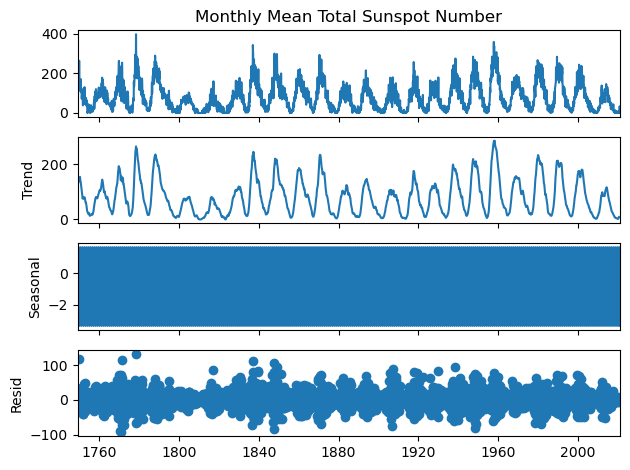

In [6]:
result = seasonal_decompose(sunspots_data['Monthly Mean Total Sunspot Number'], model='additive', period=12)
result.plot()
plt.show()

Within the decompoition graph we can notice some underlying patterns:

Trend: Shows the long-term progression of sunspot counts, indicating periods of increasing or decreasing solar activity.

Seasonality: Exhibits the regular pattern within a year, which seems negligible given the flatness of the seasonal component in the graph, suggesting little to no monthly seasonal effect in the sunspot numbers.

Residuals: Display irregularities or 'noise' that are not explained by the trend or seasonality. These could be random variations or non-systematic outliers.

The residuals indicate that while the trend and cyclical nature account for much of the sunspot activity, there are still considerable unexplained variations that could be due to random or complex factors not captured by a simple seasonal decomposition.

In [7]:
adf_test = adfuller(sunspots_data['Monthly Mean Total Sunspot Number'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF Statistic: -10.497051662546147
p-value: 1.1085524921956021e-18


The ADF test looks at the null hypothesis that a unit root is present in the time series sample, which would imply that the time series is non-stationary and has a structure that may change over time

A more negative ADF statistic means that we can reject the null hypothesis with greater confidence. Here, the ADF statistic is quite negative, which suggests that the null hypothesis can be rejected.

The p-value indicates the probability of observing the data if the null hypothesis were true. In this case, the p-value is extremely low (practically zero), far below any common significance level (e.g., 0.05, 0.01), which strongly suggests that the null hypothesis of a unit root can be rejected.

In [8]:
# making a non-stationary time series stationary
if adf_test[1] > 0.05:
    sunspots_data['Sunspots_diff'] = sunspots_data['Sunspots'].diff().dropna()

In [9]:
train = sunspots_data['Monthly Mean Total Sunspot Number'][:'1990']
test = sunspots_data['Monthly Mean Total Sunspot Number']['1991':]

In [17]:
train.index.freq = 'ME'
model = SARIMAX(train, order=(5,1,0), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

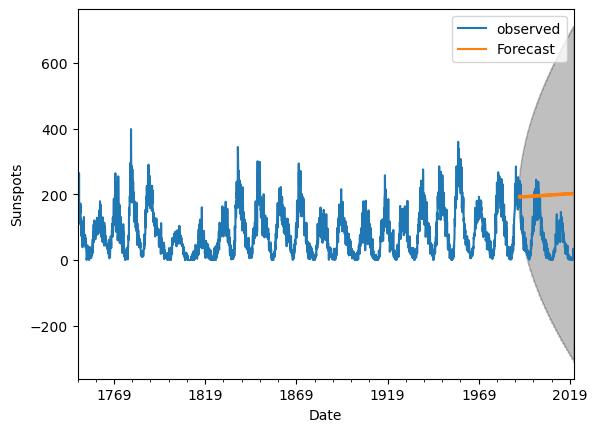

In [18]:
predictions = results.get_forecast(steps=len(test))
predictions_ci = predictions.conf_int()
ax = sunspots_data['Monthly Mean Total Sunspot Number'].plot(label='observed')
predictions.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(predictions_ci.index,
                predictions_ci.iloc[:, 0],
                predictions_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sunspots')
plt.legend()
plt.show()

In [35]:
mse = mean_squared_error(test, predictions.predicted_mean)
rmse = np.sqrt(mse)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Squared Error: 20528.383513881312
Root Mean Squared Error: 143.27729587719512


The relatively low RMSE in comparison to the range of sunspot numbers (which typically varies from 0 to over 400) suggests that the model has a satisfactory predictive performance